In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

from detectshift.utils import *
from detectshift.exp_utils import *
from detectshift.tests import *
from detectshift.cd_models import *

####### Fixing Seed #######
random_seed=42
np.random.seed(random_seed)
###########################

%config InlineBackend.figure_format = 'retina'

In [2]:
values1 = [0]
print(values1, len(values1))

values2 = [0]
print(values2, len(values2))

[0] 1
[0] 1


In [3]:
B=9
n_p=100000
alpha=.05
perc=list(range(20,100,20)) #percentiles for binning
n =100

# Label & Conc. 1 

In [4]:
d=3
task='class'
test=.5

## Label shift

In [5]:
pvals=[]

for k in tqdm(range(n_p)):
    for gamma in [0]:
        for delta in values1:

            ### Generating data ###
            Xs, ys, Xt, yt = GenData2(gamma, delta, d=d, n=n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)            
        
            ### Ztest ###
            pval_z=ztest(ys, yt)
            
            ### TV ###
            labelshift=tv(ys, yt)
            y = np.hstack((ys, yt))
            labelperm = []
            for b in range(B):
                shuffle = np.random.choice(range(y.shape[0]), size=(y.shape[0],), replace=False)
                inds = shuffle[:ys.shape[0]]
                indt = shuffle[ys.shape[0]:]
                labelperm.append(tv(y[inds],y[indt]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            labelperm=np.array(labelperm)
            labelperm=labelperm+np.random.normal(0,s,labelperm.shape[0])
            labelshift=labelshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(labelperm) >= labelshift))/(B+1)
            
            
            ### Ours ###
            lab=PermutDiscrete(get_dummies(ys), get_dummies(yt), B=B, verbose=False)
            pval_kl = lab['pval']
 
            ### Output ###
            pvals.append([delta, pval_z, pval_tv, pval_kl])

100%|██████████| 100000/100000 [17:27<00:00, 95.46it/s]


In [6]:
pvals=np.array(pvals)



  ********** Z **********


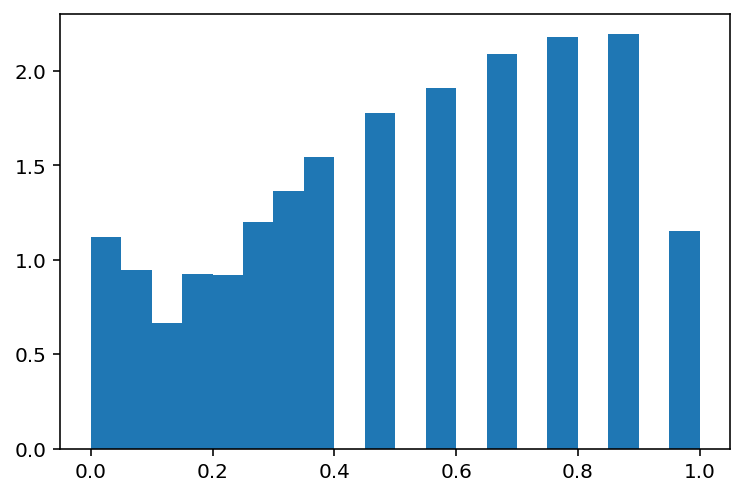

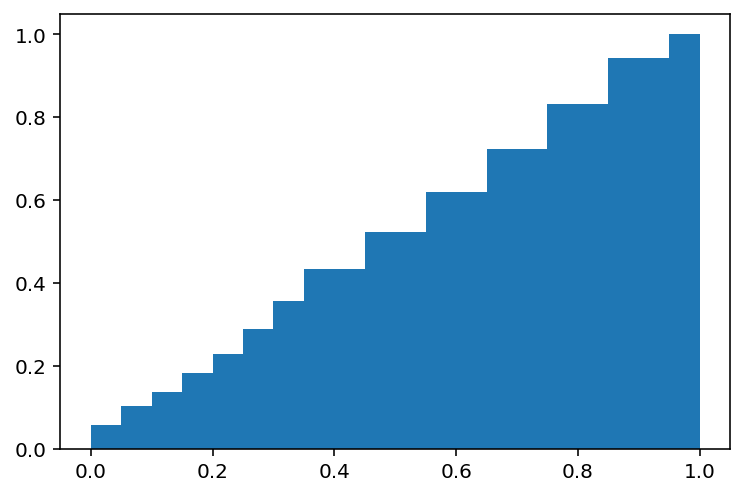



  ********** TV **********


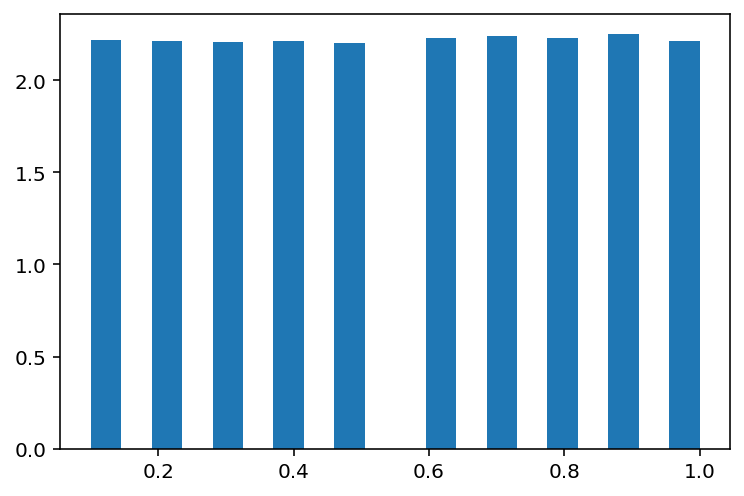

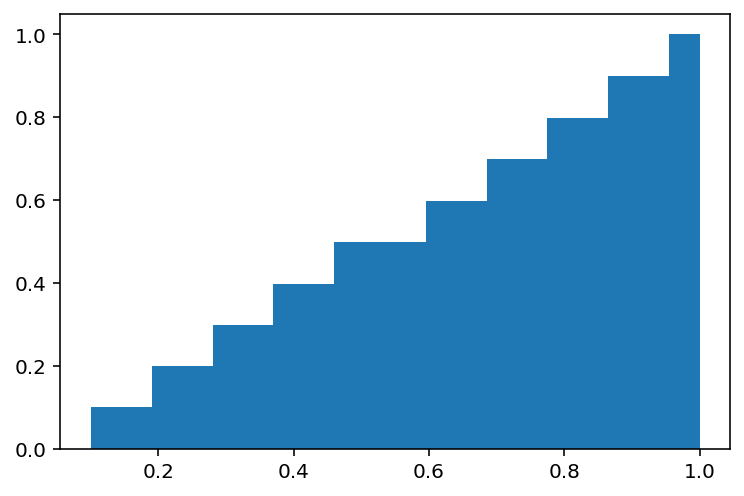



  ********** KL (ours) **********


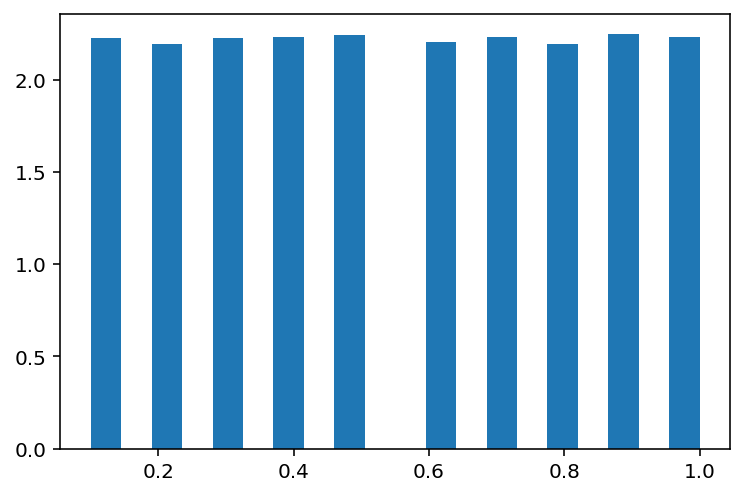

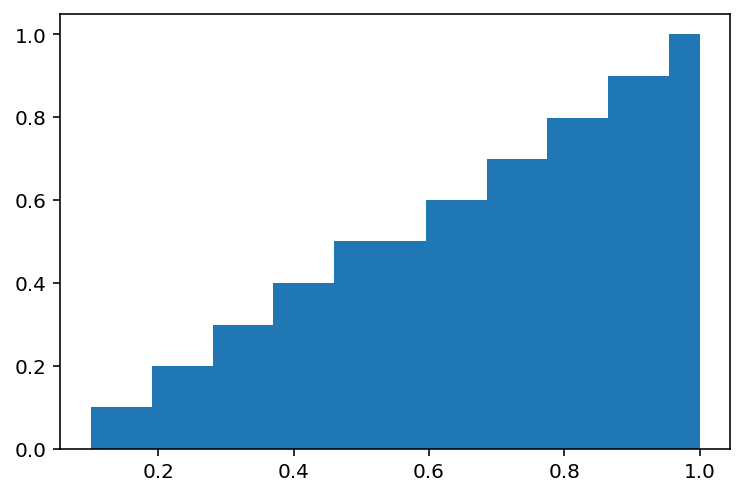

In [7]:
names=['Z','TV','KL (ours)']
for i in range(3):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()

## Conc shift 1 


In [8]:
pvals=[]

for k in tqdm(range(n_p)):
    for gamma in values1:
        for delta in [0]:

            ### Generating data ###
            Xs, ys, Xt, yt = GenData2(gamma, delta, d=d, n=n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)            

            ### TV
            Xbins = np.percentile(np.vstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)
            
            df = pd.DataFrame(Xs_bin, dtype='str')
            df['concat'] = df[0] +  df[1] + df[2]
            Xs_bin=np.array(df['concat'], dtype='int')
            
            df = pd.DataFrame(Xt_bin, dtype='str')
            df['concat'] = df[0] +  df[1] + df[2] 
            Xt_bin=np.array(df['concat'], dtype='int')
            
            y = np.hstack((ys,yt))
            X_bin = np.hstack((Xs_bin,Xt_bin))
            
            concshift=tv_conc(ys,Xs_bin,yt,Xt_bin)
            concperm = []
            Y=np.unique(np.array(y))
            ind={}
            for j in Y:
                ind[j] = (np.array(y)==j).squeeze()

            for b in range(B):
                X_perm = np.zeros(X_bin.shape)
                shuffle={}
                for j in Y:
                    shuffle[j] = np.random.choice(range(np.sum(ind[j])), size=(np.sum(ind[j]),), replace=False)
                    X_perm[ind[j]] = X_bin[ind[j]][shuffle[j]]

                concperm.append(tv_conc(ys,X_perm[:Xs_bin.shape[0]],yt,X_perm[Xs_bin.shape[0]:]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            concperm=np.array(concperm)
            concperm=concperm+np.random.normal(0,s,concperm.shape[0])
            concshift=concshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(concperm) >= concshift))/(B+1)
            
            
            ### Ours ###
            totshift_model = KL(boost=False, cv=None)
            totshift_model.fit(Zs_train, Zt_train)

            conc1=LocalPermut(Xs_test, ys_test, Xt_test, yt_test, 
                              totshift_model, labshift_model=None, task=task, B=B, verbose=False)
        
            pval_kl = conc1['pval']
 

            ### Output ###
            pvals.append([gamma, pval_tv, pval_kl])

100%|██████████| 100000/100000 [2:18:59<00:00, 11.99it/s] 


In [9]:
pvals=np.array(pvals)



  ********** TV **********


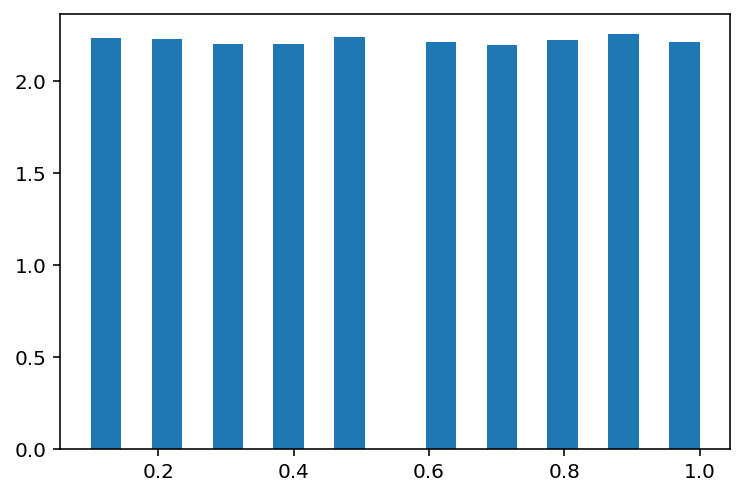

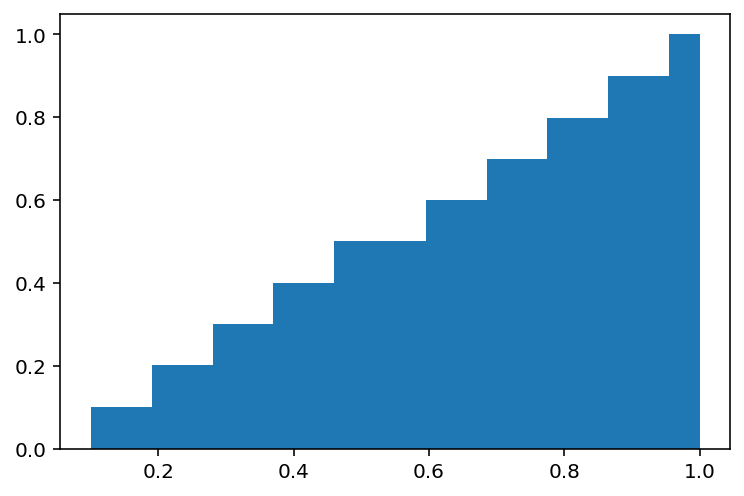



  ********** KL (ours) **********


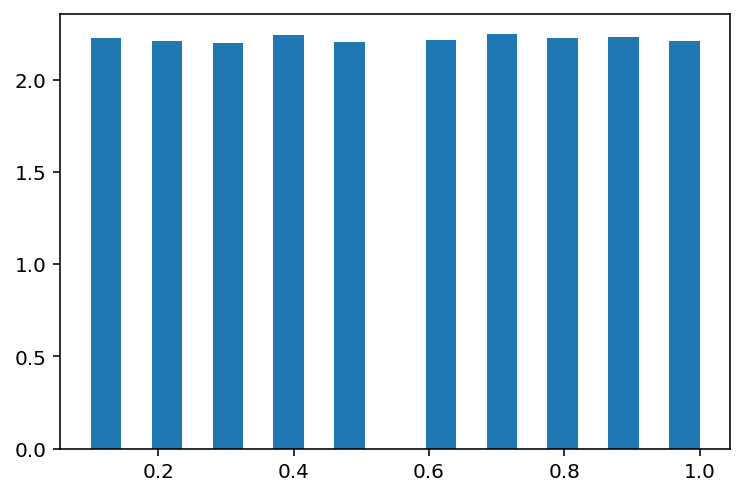

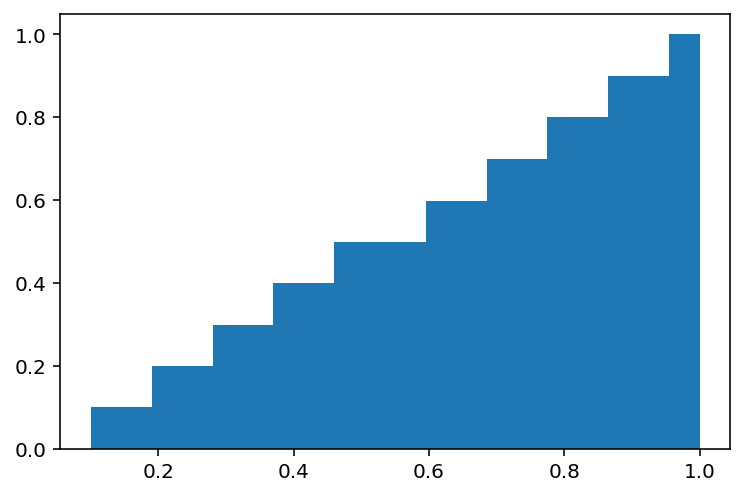

In [10]:
names=['TV','KL (ours)']
for i in range(2):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()

# Cov. & Conc. 2 shifts

In [11]:
task='reg'

## Cov. shift

In [12]:
pvals=[]

for k in tqdm(range(n_p)):
    for theta in [0]:
        for lamb in values2:

            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)
            Xs, ys, Xt, yt = Xs.squeeze(), ys.squeeze(), Xt.squeeze(), yt.squeeze()
            
            ### KS ###
            pval_ks=list(stats.ks_2samp(Xs,Xt))[1]
            
            ### TV ###
            Xbins = np.percentile(np.hstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)

            covshift=tv(Xs_bin,Xt_bin)
            X_bin = np.hstack((Xs_bin,Xt_bin))
            covperm = []
            for b in range(B):
                shuffle = np.random.choice(range(X_bin.shape[0]), size=(X_bin.shape[0],), replace=False)
                inds = shuffle[:Xs_bin.shape[0]]
                indt = shuffle[Xs_bin.shape[0]:]
                covperm.append(tv(X_bin[inds],X_bin[indt]))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            covperm=np.array(covperm)
            covperm=covperm+np.random.normal(0,s,covperm.shape[0])
            covshift=covshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(covperm) >= covshift))/(B+1)
            
            
            ### Ours ###
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)
            
            cov=Permut(Xs_test, Xt_test, covshift_model, B=B, verbose=False)
            pval_kl = cov['pval']
            
            ### Output ###
            pvals.append([lamb, pval_ks, pval_tv, pval_kl])

100%|██████████| 100000/100000 [14:13<00:00, 117.15it/s]


In [13]:
pvals=np.array(pvals)



  ********** KS **********


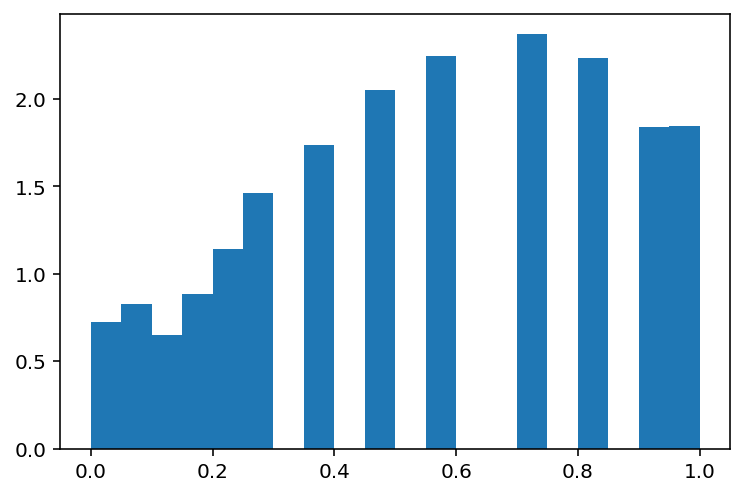

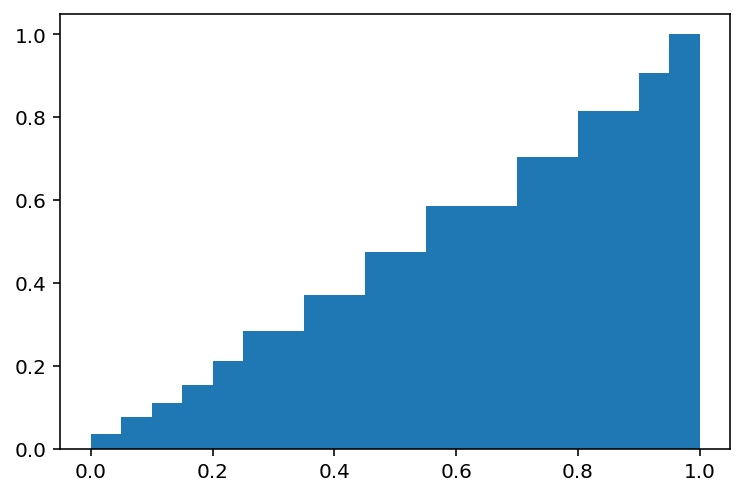



  ********** TV **********


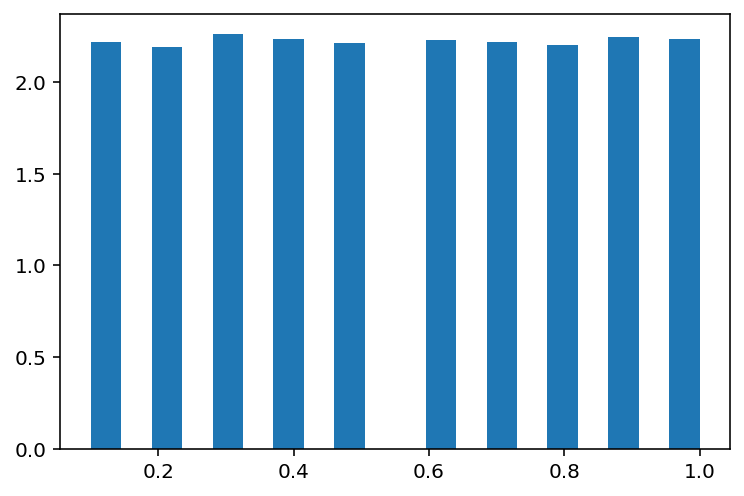

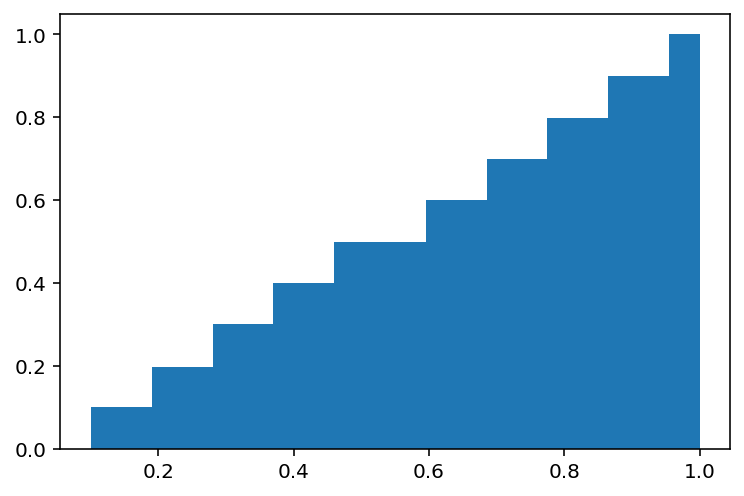



  ********** KL (ours) **********


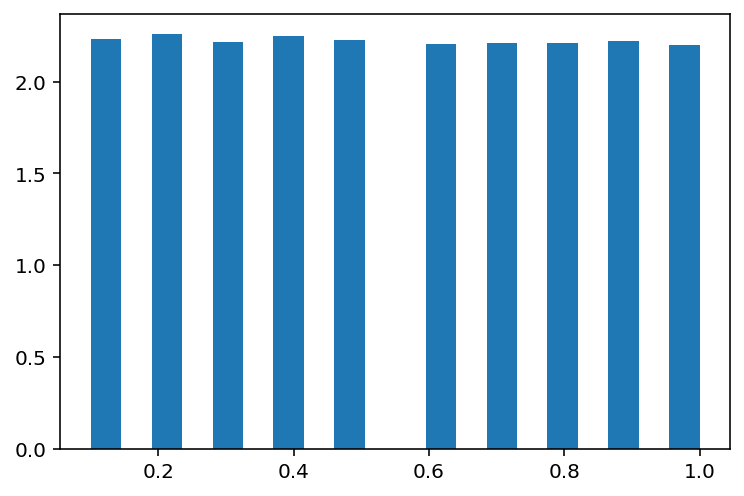

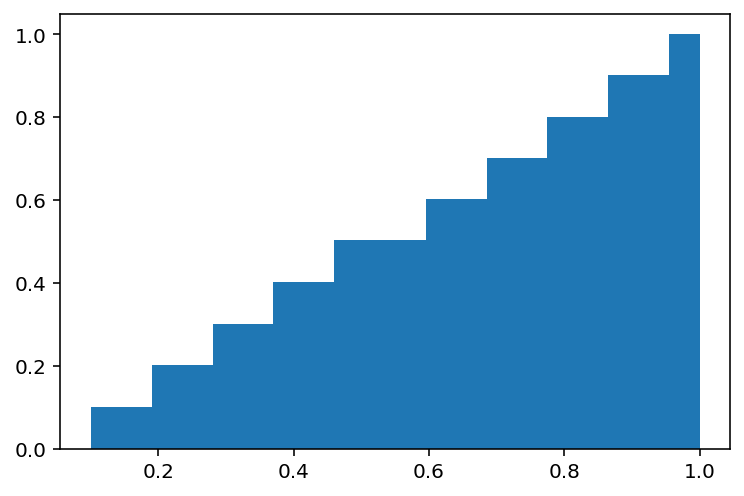

In [14]:
names=['KS','TV','KL (ours)']
for i in range(3):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()

## Conc shift 2 

In [15]:
class cde_regH0:
    def sample(self, X):      
        return pd.DataFrame(np.random.normal(X, 1))

In [16]:
pvals=[]

for k in tqdm(range(n_p)):
    for theta in values2:
        for lamb in [0]:
            
            # Training CDE
            cde = cde_regH0()
            
            ### Setting-up data
            Xs, ys, Xt, yt = GenData(theta, lamb, n)
            Xs_train, Xs_test, ys_train, ys_test, Zs_train, Zs_test, \
            Xt_train, Xt_test, yt_train, yt_test, Zt_train, Zt_test = prep_data(Xs, ys, Xt, yt, test=test, task=task, random_state=random_seed)

            ### TV ###
            #(we use only the test set because we used the training set to train the cde)
            Xs, ys, Xt, yt = Xs_test.squeeze(), ys_test.squeeze(), Xt_test.squeeze(), yt_test.squeeze()
            
            Xbins = np.percentile(np.hstack((Xs,Xt)), q=perc)
            Xs_bin, Xt_bin = np.digitize(Xs, Xbins), np.digitize(Xt, Xbins)
            ybins = np.percentile(np.hstack((ys,yt)), q=perc)
            ys_bin, yt_bin = np.digitize(ys, ybins), np.digitize(yt, ybins)
            
            concshift=tv_conc(Xs_bin,ys_bin,Xt_bin,yt_bin)
            concperm = []

            for b in range(B):
                ys_hat, yt_hat = cde.sample(Xs), cde.sample(Xt)
                ybins = np.percentile(np.hstack((ys_hat,yt_hat)), q=perc)
                ys_bin_hat, yt_bin_hat = np.digitize(ys_hat, ybins), np.digitize(yt_hat, ybins)
                concperm.append(tv_conc(Xs_bin,ys_bin_hat,Xt_bin,yt_bin_hat))

            #Enforcing uniformity of p-values under H0 (adding a very small random number - we guarantee every statistic has a different value)
            s=10**-10
            concperm=np.array(concperm)
            concperm=concperm+np.random.normal(0,s,concperm.shape[0])
            concshift=concshift+np.random.normal(0,s,1)
            
            pval_tv=(1+np.sum(np.array(concperm) >= concshift))/(B+1)
            
            ### Ours ###
            totshift_model = KL(boost=False, cv=None)
            totshift_model.fit(Zs_train, Zt_train)
            covshift_model = KL(boost=False, cv=None)
            covshift_model.fit(Xs_train, Xt_train)

            ###
            conc2=CondRand(Xs_test, ys_test, Xt_test, yt_test, 
                           cde, totshift_model, covshift_model, B=B, verbose=False)
            
            pval_kl = conc2['pval']
            
            ### Output ###
            pvals.append([theta, pval_tv, pval_kl])

100%|██████████| 100000/100000 [38:43<00:00, 43.05it/s]


In [17]:
pvals=np.array(pvals)



  ********** TV **********


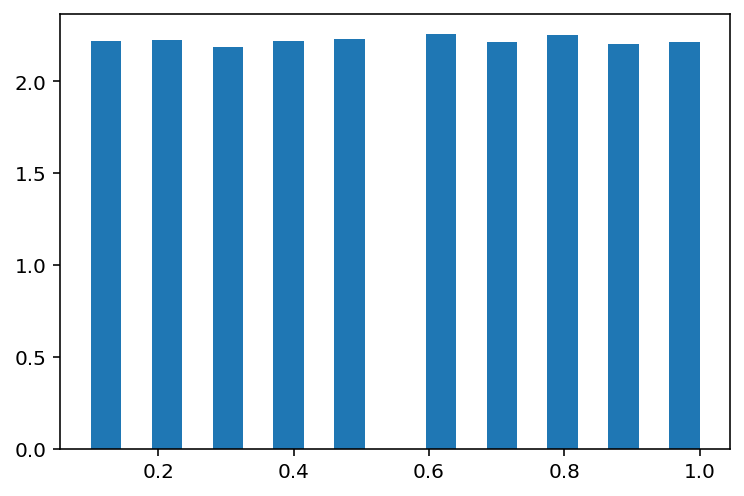

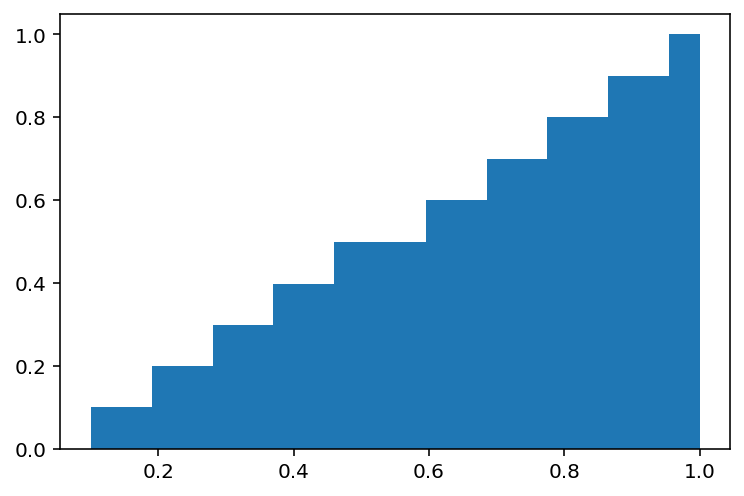



  ********** KL (ours) **********


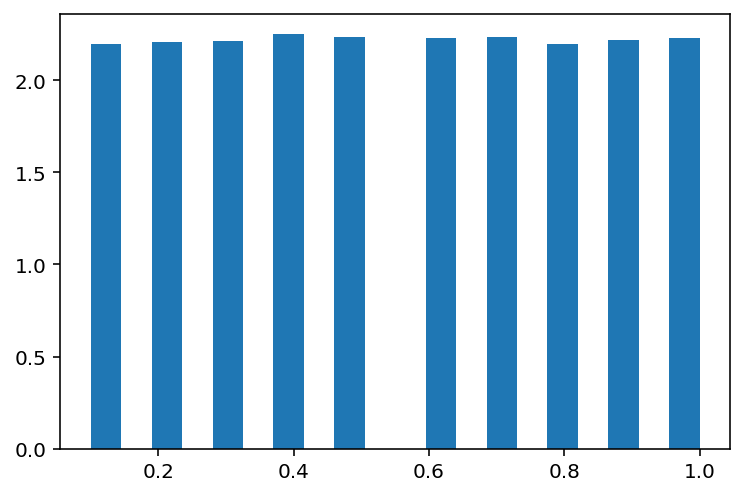

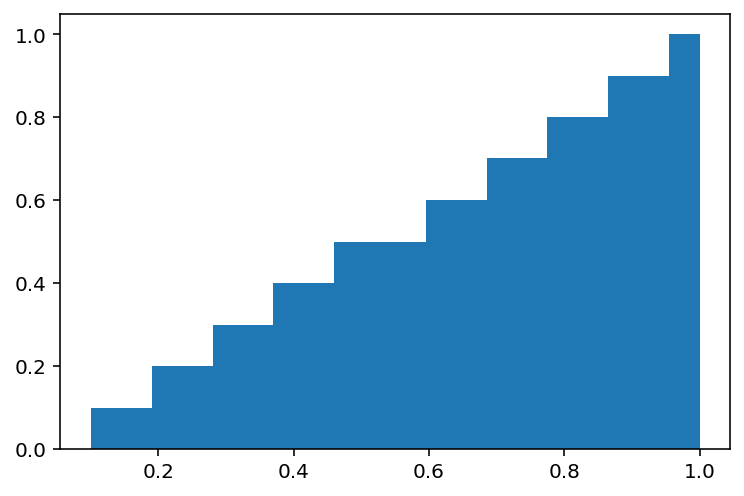

In [18]:
names=['TV','KL (ours)']
for i in range(2):
    print("\n\n  **********",names[i],"**********")
    plt.hist(pvals[:,i+1], cumulative=False, density=True, bins=20)
    plt.show()
    plt.hist(pvals[:,i+1], cumulative=True, density=True, bins=20)
    plt.show()